In [13]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')

In [14]:
class LinearRegressor():
    def __init__(self):
        self.coefficients = None

    def fit(self, X, y):
        "Computes the coefficients based on the dataset received by the model"
        self.coefficients = np.matmul(np.matmul(LA.inv(np.matmul(X.T, X)), X.T), y)
        return self.coefficients

    def predict(self, X):
        "Returns a prediction based on the learnt model and using the parameter passed"
        return np.matmul(X, self.coefficients)

    def score(self, X, y):
        "Given a know input and output vectors, computes and returns the least square error"

        diff = np.squeeze(self.predict(X) - y)
        return np.dot(diff, diff)
    
    
class DimensionalityReductor():
    def __init__(self, X):
        self.X = X
        
    def reduce(self, n_dim):
        return NotImplemented


class PCADimensionalityReductor(DimensionalityReductor):
    def __init__(self, X):
        super().__init__(X)
        self.eig_vectors=None
        
        # Sorting eigen values
        mean = np.mean(self.X, axis=0)
        self.centred_matrix = self.X - mean
        cov_matrix = (1/(self.centred_matrix.shape[0]))*((np.dot(self.centred_matrix.T,self.centred_matrix)))
        eigen_vals, eigen_vecs = LA.eig(cov_matrix)
        
        indices = np.argsort(eigen_vals)[::-1]
        sorted_eigen_vals = eigen_vals[indices]
        self.sorted_eigen_vecs = eigen_vecs[:,indices]
        
    def reduce(self, n_dim):
        """
        Returns a modified dataset with n_dim features computed based on the area of high variance
        """

        eigenvector_subset = self.sorted_eigen_vecs[:,0:n_dim]
        X_reduced = np.dot(eigenvector_subset.transpose() , self.centred_matrix.transpose() ).transpose()

        return X_reduced

# The dataset that will be used in this assignment was adapted from the Covid-19 and Character Strengths dataset on Kaggle (https://www.kaggle.com/mathchi/covid19-and-character-strengths).

# The purpose of this study is to investigate the role of character strengths on psychological distress during the Covid-19 lockdown

In [20]:
# Load the dataset from the DB.xlsx file 
dataset = pd.read_excel("DB.xlsx")

#Retrieve the shape of the dataset
shape = dataset.shape
print("Shape of the dateset is:", shape)

Shape of the dateset is: (944, 41)


In [16]:
# TODO: Retrieve the features into the X array, and the output to the y array
X = dataset[['Appreciation_of_beauty', 'Bravery',
'Creativity', 'Curiosity', 'Fairness', 'Forgiveness', 'Gratitude',
'Honesty', 'Hope', 'Humilty', 'Humor', 'Judgment', 'Kindness',
'Leadership', 'Love', 'Love_of_learning', 'Perseverance', 'Perspective',
'Prudence', 'Self_regulation', 'Social_intelligence', 'Spirituality',
'Teamwork', 'Zest']]
y = dataset[['DASS_21']]

# Apply min-max normalization on each of the columns of the X array
X =(X-X.min())/(X.max()-X.min())


# (Optional) Let's convert our data to NumPy array before continuing
X = np.array(X)
y = np.array(y)

# Declare the objects that we need 
pca_dr = PCADimensionalityReductor(X)
lr = LinearRegressor()

# Now we want to see how changing the number of important features can or cannot affect the performance of our models.
scores = []
k=1
while k < 24:
    reduced = pca_dr.reduce(k)
    X_train, X_test, y_train, y_test = train_test_split(reduced, y, test_size=0.25, random_state=32)
    lr.fit(X_train, y_train)
    score = lr.score(X_test, y_test)
    scores.append(score)
    k=k+1
    

# Let's train using our full dataset
X_train, X_test, y_train, y_test = train_test_split(pca_dr.reduce(24), y, test_size=0.25, random_state=32)
lr.fit(X_train, y_train)
score = lr.score(X_test, y_test)
scores.append(score)

full_preditions = lr.predict(X_test)

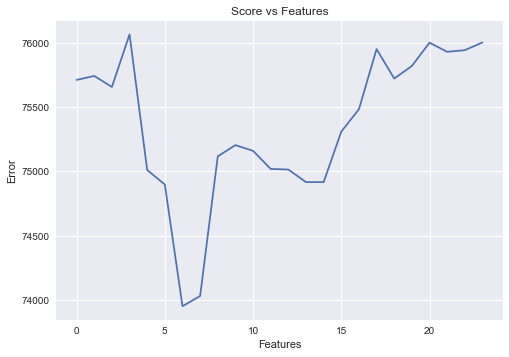

In [17]:
# Visualization
#Plot the score gotten on the test dataset against the number of features used to train the model. Note that the full dataset corresponds to 24 features

plt.plot(range(24), scores)
plt.ylabel("Error")
plt.xlabel("Features")
plt.title("Score vs Features")
plt.show()

In [18]:
# Prediction
#Predict the Depression Anxiety and Stress Scale (DASS_21) using the full dataset and using the 5 most important features
# Fit the model first with correct number of features before predicting
reducedx = pca_dr.reduce(5)
X_train, X_test, y_train, y_test = train_test_split(reducedx, y, test_size=0.25, random_state=32)
lr.fit(X_train, y_train)
five_features_predictions = lr.predict(X_test)

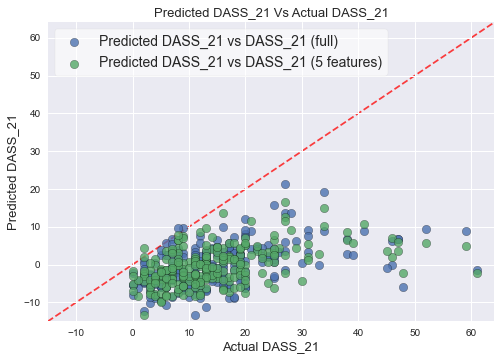

In [19]:
#Create a scatter plot of predicted DASS_21 against actual DASS_21 using the result of the full dataset
fig, ax = plt.subplots()
ax.scatter(y_test, full_preditions, label="Predicted DASS_21 vs DASS_21 (full)",edgecolors='k', alpha=0.8,s=70)
ax.set_title("Predicted DASS_21 Vs Actual DASS_21",fontsize=13)
ax.set_xlabel("Actual DASS_21",fontsize=13)
ax.set_ylabel("Predicted DASS_21",fontsize=13)

# On the same figure create a scatter plot of predicted DASS_21 against actual DASS_21 using the result of the 5 most important features
ax.scatter(y_test, five_features_predictions, label="Predicted DASS_21 vs DASS_21 (5 features)",edgecolors='k', alpha=0.8,s=70)
ax.set_xlabel("Actual DASS_21",fontsize=13)
ax.set_ylabel("Predicted DASS_21",fontsize=13)
ax.legend(frameon=True,facecolor='white',framealpha=0.6,fontsize=14)

# Use two different colors to differentiate the two scatter plots and make sure to label them
# Plot a line dashed line y = x to visually appreciate how far the predicted DASS_21 is from the actual DASS_21
lims = [
np.min([ax.get_xlim(), ax.get_ylim()]),
np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()